In [1]:
import pandas as pd
import datetime
import numpy as np
# users_location = pd.read_csv('tweet_location_parsed.tsv', sep='\t', dtype="str")
elections = pd.read_csv('../data/wybory.csv', sep=';', dtype="str")

elections

,Nr OKW,Kod TERYT,Powiat,Województwo,Frekwencja,% głosów nieważnych,W tym z powodu postawienia znaku „X” obok nazwiska dwóch lub większej liczby kandydatów,W tym z powodu niepostawienia znaku „X” obok nazwiska żadnego kandydata,W tym z powodu postawienia znaku „X” wyłącznie obok skreślonego nazwiska kandydata,% głosów ważnych,Andrzej Sebastian DUDA,Rafał Kazimierz TRZASKOWSKI,Liczba obwodów
0,2,020100,bolesławiecki,dolnośląskie,"62,79","0,76","55,59","44,41",NaN,"99,24","49,63","50,37",63
1,4,020200,dzierżoniowski,dolnośląskie,"62,64","0,85","56,90","43,10",NaN,"99,15","50,44","49,56",83
2,3,020300,głogowski,dolnośląskie,"66,71","0,82","63,64","36,36",NaN,"99,18","51,78","48,22",53
3,1,020400,górowski,dolnośląskie,"59,29","0,87","49,28","50,72",NaN,"99,13","57,00","43,00",23
4,2,020500,jaworski,dolnośląskie,"62,72","0,97","56,25","43,75",NaN,"99,03","54,44","45,56",39
...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,49,321700,wałecki,zachodniopomorskie,"62,43","0,74","56,99","43,01",NaN,"99,26","41,55","58,45",37
378,48,321800,łobeski,zachodniopomorskie,"57,82","0,75","45,08","54,92",NaN,"99,25","48,56","51,44",29
379,49,326100,Koszalin,zachodniopomorskie,"70,06","0,76","54,19","45,81",NaN,"99,24","35,25","64,75",53
380,48,326200,Szczecin,zachodniopomorskie,"70,43","0,85","61,91","38,09",NaN,"99,15","36,32","63,68",207


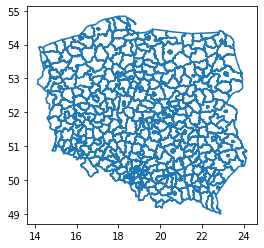

In [2]:
import geopandas
# import geoplot
import shapely
from shapely.geometry import Point

filename = "../data/powiaty.geojson"
file = open(filename)
df = geopandas.read_file(file)

df.boundary.plot()

In [3]:
df

,id,nazwa,geometry
0,1,powiat ropczycko-sędziszowski,"POLYGON ((21.80340 50.15140, 21.80300 50.15010..."
1,2,powiat łosicki,"POLYGON ((22.71870 52.33400, 22.72030 52.33430..."
2,3,powiat piaseczyński,"POLYGON ((21.16500 52.14470, 21.17110 52.13760..."
3,4,powiat radomski,"POLYGON ((21.20550 51.58870, 21.20500 51.58840..."
4,5,powiat sierpecki,"POLYGON ((19.44470 52.93900, 19.44500 52.93940..."
...,...,...,...
375,376,powiat Żory,"MULTIPOLYGON (((18.65680 50.08130, 18.65850 50..."
376,377,powiat nowodworski,"POLYGON ((19.64870 54.45330, 19.63570 54.39220..."
377,378,powiat jaworski,"POLYGON ((16.20390 50.88570, 16.20030 50.88570..."
378,379,powiat poznański,"POLYGON ((16.72980 52.56610, 16.73150 52.56780..."


In [4]:
def get_votes(row):
    return elections[elections.Powiat == row.nazwa[7:]].iloc[0]['Andrzej Sebastian DUDA']

df['votes'] = df.apply(lambda row: get_votes(row), axis=1)
df['votes'] = df['votes'].str.replace(',', '.').astype(float)

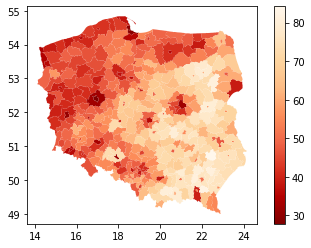

In [5]:
import matplotlib.pyplot as plt  
from  matplotlib.colors import LinearSegmentedColormap

df.plot(column='votes', cmap='OrRd_r', legend=True);
plt.savefig("europe.png")

# Spatial autocorrelation

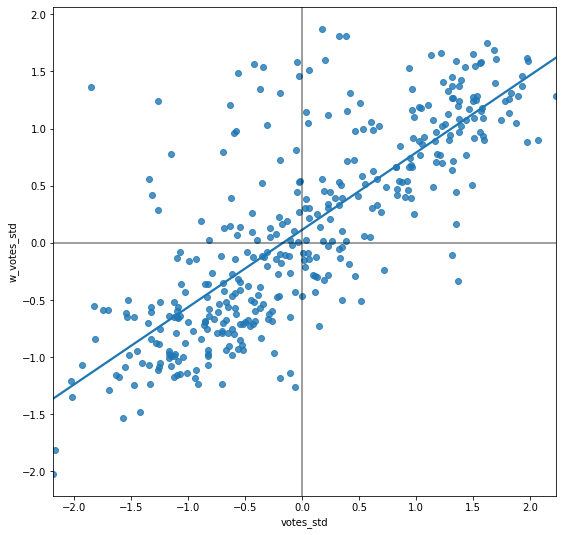

In [24]:
import seaborn as sns
import pandas as pd
from pysal.lib import weights
from pysal.explore import esda
from pysal.viz.splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
import geopandas as gpd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt

w = weights.Queen.from_dataframe(df)
w.transform = 'R'

df = df.drop(w.islands)

w = weights.Queen.from_dataframe(df)
w.transform = 'R'


df['votes_std'] = (df['votes'] - df['votes'].mean()) / df['votes'].std()

df['w_votes_std'] = weights.lag_spatial(w, df['votes_std'])
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='votes_std', y='w_votes_std', data=df, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

mi = esda.Moran(df['votes'], w)

In [7]:
mi.I

0.6772134698146514

In [8]:
mi.p_sim

0.001

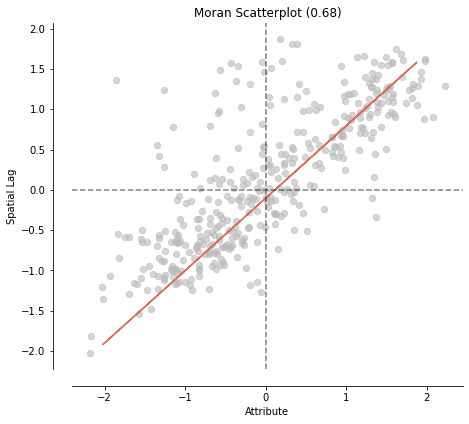

In [9]:
moran_scatterplot(mi);

In [10]:
lisa = esda.Moran_Local(df['votes'], w)

In [11]:
# Break observations into significant or not
df['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
df['quadrant'] = lisa.q

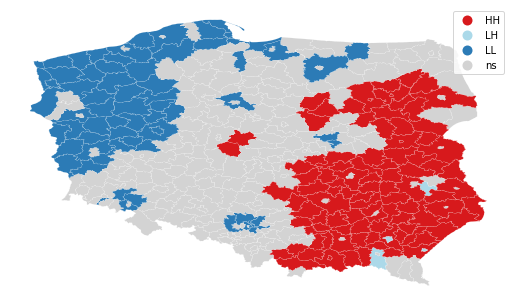

In [25]:
f, ax = plt.subplots(1, figsize=(9, 9))
ax.set_axis_off()
# plt.axis('equal')

lisa_cluster(lisa, df, ax=ax);

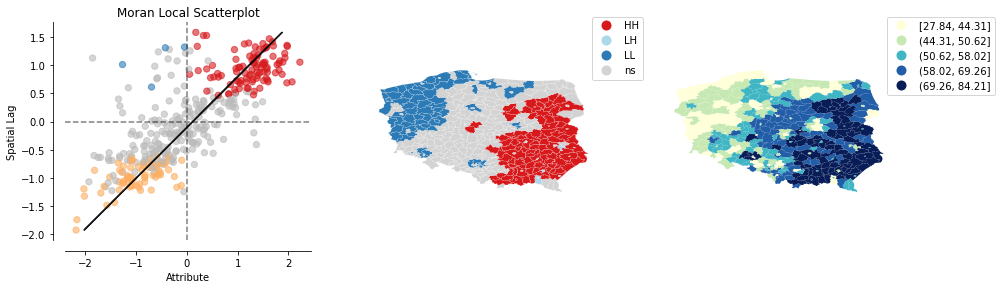

In [14]:
plot_local_autocorrelation(lisa, df, 'votes', aspect_equal=False);

# Clustering

In [15]:
from sklearn import cluster

kmeans = cluster.KMeans(n_clusters=5)
kcls = kmeans.fit(df[['votes']])
df['class'] = kcls.labels_

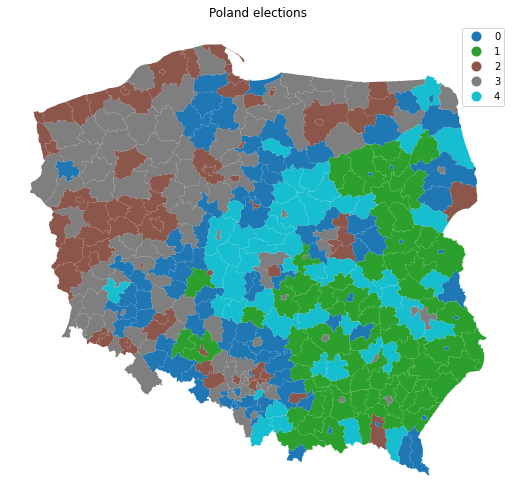

In [16]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
df.plot(column='class', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
# plt.axis('equal')
# Add title
plt.title('Poland elections')
# Display the map
plt.show()

In [17]:
k5means = df.groupby('class')[['votes']].mean()
# Show the table transposed (so it's not too wide)
k5means.T

class,0,1,2,3,4
votes,56.62023,74.910959,38.531972,48.066162,65.967


In [43]:
def create_plot_df(df, index_col, columns):
    to_plot = df.set_index(index_col)
    # Subset to keep only variables used in K-means clustering
    to_plot = to_plot[columns]
    to_plot = to_plot.stack()
    to_plot = to_plot.reset_index()
    to_plot = to_plot.rename(columns={'level_1': 'Attribute', 0: 'Values'})
    return to_plot

to_plot = create_plot_df(df, 'class', ['votes'])

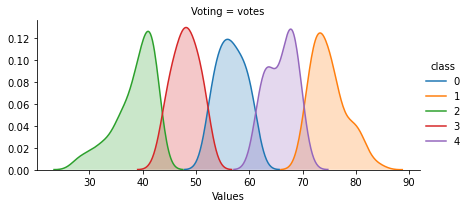

In [44]:
# Setup the facets
facets = sns.FacetGrid(data=to_plot, row='Voting', hue='class', \
                  sharey=False, sharex=False, aspect=2)
# Build the plot as a `sns.kdeplot`
_ = facets.map(sns.kdeplot, 'Values', shade=True, bw=1.5).add_legend()

# Regionalization

In [26]:
sagg = cluster.AgglomerativeClustering(n_clusters=5, connectivity=w.sparse)
sagg

AgglomerativeClustering(connectivity=<380x380 sparse matrix of type '<class 'numpy.float64'>'
	with 2006 stored elements in Compressed Sparse Row format>,
                        n_clusters=5)

In [27]:
saggcls = sagg.fit(df[['votes']])
df['saggcls'] = saggcls.labels_

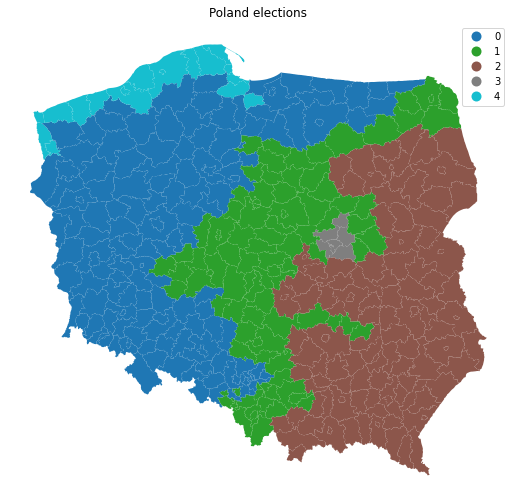

In [28]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
df.plot(column='saggcls', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
# plt.axis('equal')
# Add title
plt.title('Poland elections')
# Display the map
plt.show()

In [29]:
k5means = df.groupby('saggcls')[['votes']].mean()
# Show the table transposed (so it's not too wide)
k5means.T

saggcls,0,1,2,3,4
votes,47.019864,58.259787,68.755439,41.448333,37.472632


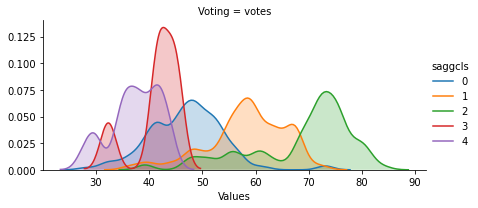

In [40]:
to_plot_reg = create_plot_df(df, 'saggcls')

facets = sns.FacetGrid(data=to_plot_reg, row='Voting', hue='saggcls', \
                  sharey=False, sharex=False, aspect=2)
# Build the plot as a `sns.kdeplot`
_ = facets.map(sns.kdeplot, 'Values', shade=True, bw=1.5).add_legend()